In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import random
import datetime
import matplotlib.pyplot as plt
import pip
pip.main(['install','seaborn'])
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from keras.applications import DenseNet121, VGG19
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout, LeakyReLU, GlobalAveragePooling2D, Conv2D, Input
from keras.optimizers import Adam
from keras.losses import BinaryFocalCrossentropy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

modelclass = '4'
suffix = 'FIN'
iterations = 5
iterations2 = 5

def CreateModel(learn_rate):
    input_tensor = Input(shape=(256, 256, 3))
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    for layer in base_model.layers[:10]:
        layer.trainable = False
        
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(negative_slope=0.01)(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=learn_rate),
                  loss=BinaryFocalCrossentropy(),
                  metrics=['accuracy'])

    return model

base_dir = '../../Data/Arrays/'
class_dir = 'Converted Arrays/'
train_images = np.load(os.path.join(base_dir, 'train_images.npy'))
train_labels = np.load(os.path.join(class_dir, f'train_labels_class{modelclass}.npy'))
val_images = np.load(os.path.join(base_dir, 'val_images.npy'))
val_labels = np.load(os.path.join(class_dir, f'val_labels_class{modelclass}.npy'))

if len(train_images.shape) == 3:
    train_images = np.expand_dims(train_images, axis=-1)
    train_images = np.repeat(train_images, 3, axis=-1)

if len(val_images.shape) == 3:
    val_images = np.expand_dims(val_images, axis=-1)
    val_images = np.repeat(val_images, 3, axis=-1)

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels.flatten())
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

print("Initial class weights:", class_weights)
print("Start time: ", datetime.datetime.now())

best_model_path = f'Models/class{suffix}{modelclass}temp.keras'
model_checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', save_best_only=True, mode='min')

best_val_loss = float('inf')
for i in range(iterations):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-7)
    model = CreateModel(1e-5)
    print(f"Training iteration {i+1}/{iterations}")
    history = model.fit(train_images, train_labels,
                        epochs=50,
                        batch_size=16,
                        validation_data=(val_images, val_labels),
                        class_weight=class_weights,
                        callbacks=[early_stopping, reduce_lr, model_checkpoint])

    model.load_weights(best_model_path)
    val_loss = min(history.history['val_loss'])
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"Best current val:{best_val_loss}")
        model.save(f'Models/class_{suffix}{modelclass}_overallbest.keras')

print("Training Complete")

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Collecting seaborn

Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)

Requirement already satisfied: numpy!=1.24.0,>=1.20 in /opt/conda/lib/python3.11/site-packages (from seaborn) (1.26.4)

Requirement already satisfied: pandas>=1.2 in /opt/conda/lib/python3.11/site-packages (from seaborn) (2.2.3)

Requirement already satisfied: matplotlib!=3.6.1,>=3.4 in /opt/conda/lib/python3.11/site-packages (from seaborn) (3.9.3)

Requirement already satisfied: contourpy>=1.0.1 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (1.3.1)

Requirement already satisfied: cycler>=0.10 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (0.12.1)

Requirement already satisfied: fonttools>=4.22.0 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (4.55.3)

Requirement already satisfied: kiwisolver>=1.3.1 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (1.4.7)

Requirement already satisfied: packaging>=20.0 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (24.2)

Requirement already satisfied: pillow>=8 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (10.4.0)

Requirement already satisfied: pyparsing>=2.3.1 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (3.2.0)

Requirement already satisfied: python-dateutil>=2.7 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (2.9.0.post0)

Requirement already satisfied: pytz>=2020.1 in /opt/conda/lib/python3.11/site-packages (from pandas>=1.2->seaborn) (2023.3)

Requirement already satisfied: tzdata>=2022.7 in /opt/conda/lib/python3.11/site-packages (from pandas>=1.2->seaborn) (2024.2)

Requirement already satisfied: six>=1.5 in /opt/conda/lib/python3.11/site-packages (from python-dateutil>=2.7->matplotlib!=3.6.1,>=3.4->seaborn) (1.17.0)

Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)

Installing collected packages: seaborn

Successfully installed seaborn-0.13.2

Initial class weights: {0: 0.5341638354095886, 1: 7.81767955801105}
Start time:  2025-01-16 09:06:22.889048


I0000 00:00:1737018383.035365    1704 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737018383.089135    1704 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737018383.092448    1704 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737018383.096629    1704 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Training iteration 1/5
Epoch 1/50


I0000 00:00:1737018395.660212    1766 service.cc:146] XLA service 0x7f5cb4008370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737018395.660248    1766 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5


  1/354 ━━━━━━━━━━━━━━━━━━━━ 2:08:03 22s/step - accuracy: 0.3750 - loss: 0.2157

I0000 00:00:1737018414.359573    1766 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.4910 - loss: 0.2025

E0000 00:00:1737018484.321391    1762 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737018484.539827    1762 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


354/354 ━━━━━━━━━━━━━━━━━━━━ 115s 265ms/step - accuracy: 0.4911 - loss: 0.2025 - val_accuracy: 0.0698 - val_loss: 0.1755 - learning_rate: 1.0000e-05
Epoch 2/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 73s 206ms/step - accuracy: 0.4778 - loss: 0.1745 - val_accuracy: 0.9311 - val_loss: 0.1696 - learning_rate: 1.0000e-05
Epoch 3/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 72s 203ms/step - accuracy: 0.4895 - loss: 0.1767 - val_accuracy: 0.0689 - val_loss: 0.1778 - learning_rate: 1.0000e-05
Epoch 4/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 72s 203ms/step - accuracy: 0.2544 - loss: 0.1761 - val_accuracy: 0.0689 - val_loss: 0.1739 - learning_rate: 1.0000e-05
Epoch 5/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 72s 203ms/step - accuracy: 0.4222 - loss: 0.1761 - val_accuracy: 0.0769 - val_loss: 0.1736 - learning_rate: 3.0000e-06
Epoch 6/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 72s 203ms/step - accuracy: 0.4801 - loss: 0.1702 - val_accuracy: 0.2518 - val_loss: 0.1734 - learning_rate: 3.0000e-06
Epoch 7/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 72s 203ms/step -

In [2]:
best_model_path = f'Models/class{suffix}secondary{modelclass}temp.keras'
model_checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', save_best_only=True, mode='min')
best_val_loss = float('inf')
for i in range (iterations2):
    model = CreateModel(1e-7)
    model.load_weights(f'Models/class_{suffix}{modelclass}_overallbest.keras')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-8)
    
    print(f"Training iteration {i+1}/{iterations2}")
    history = model.fit(train_images, train_labels,
                        epochs=50,
                        batch_size=16,
                        validation_data=(val_images, val_labels),
                        class_weight=class_weights,
                        callbacks=[early_stopping, reduce_lr, model_checkpoint])

    model.load_weights(best_model_path)
    val_loss = min(history.history['val_loss'])
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"Best last val:{val_loss}")
        print(f"Best current val:{best_val_loss}")
        model.save(f'Models/class_{suffix}{modelclass}_overallbestFIN.keras')

/opt/conda/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training iteration 1/5
Epoch 1/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 80s 215ms/step - accuracy: 0.8318 - loss: 0.1752 - val_accuracy: 0.9311 - val_loss: 0.1660 - learning_rate: 1.0000e-07
Epoch 2/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 72s 202ms/step - accuracy: 0.8410 - loss: 0.1753 - val_accuracy: 0.9311 - val_loss: 0.1665 - learning_rate: 1.0000e-07
Epoch 3/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 72s 202ms/step - accuracy: 0.8371 - loss: 0.1713 - val_accuracy: 0.9311 - val_loss: 0.1667 - learning_rate: 1.0000e-07
Epoch 4/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 72s 202ms/step - accuracy: 0.8389 - loss: 0.1712 - val_accuracy: 0.9311 - val_loss: 0.1671 - learning_rate: 1.0000e-07
Epoch 5/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 72s 202ms/step - accuracy: 0.8283 - loss: 0.1682 - val_accuracy: 0.9311 - val_loss: 0.1671 - learning_rate: 1.0000e-08
Epoch 6/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 72s 202ms/step - accuracy: 0.8271 - loss: 0.1725 - val_accuracy: 0.9311 - val_loss: 0.1671 - learning_rate: 1.0000e-08
Best last val:0.1660294

24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 541ms/step - accuracy: 0.9387 - loss: 0.1650
Test Loss: 0.1651669293642044
Test Accuracy: 0.931125819683075
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step


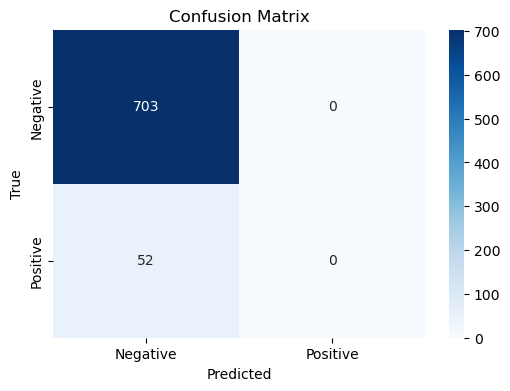

E0000 00:00:1737024012.593653    1764 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737024012.788837    1764 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


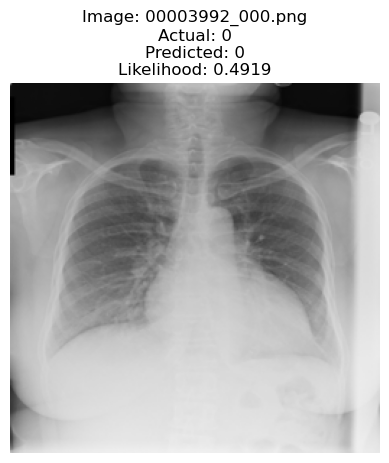

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


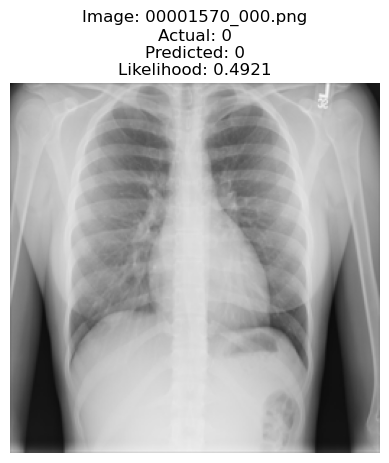

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


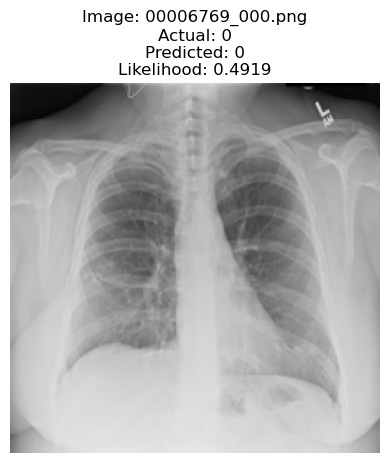

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


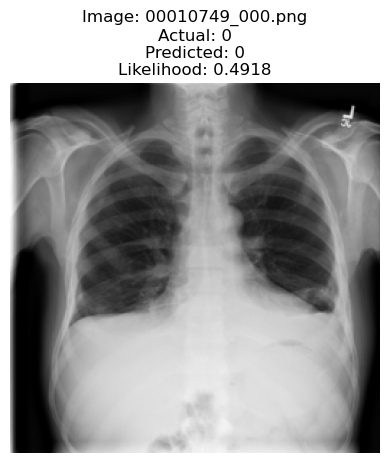

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


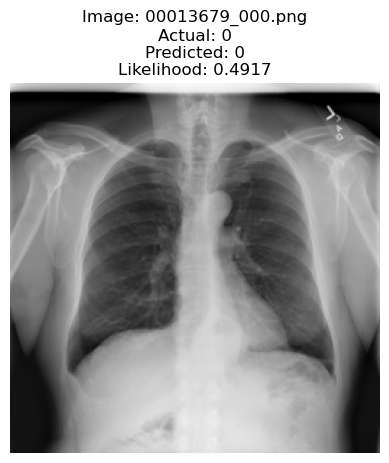

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


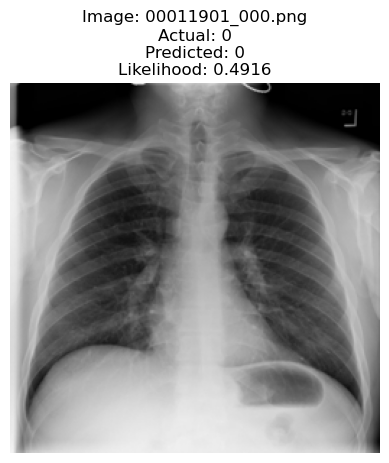

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


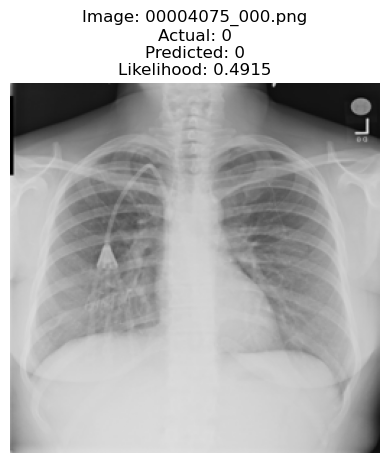

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


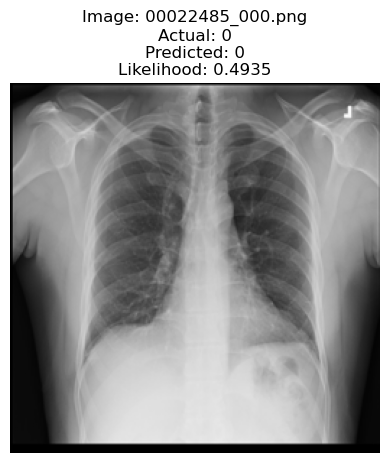

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


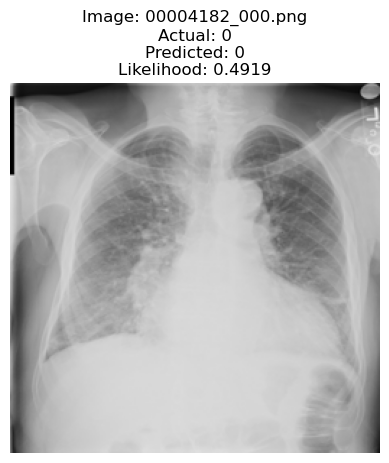

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


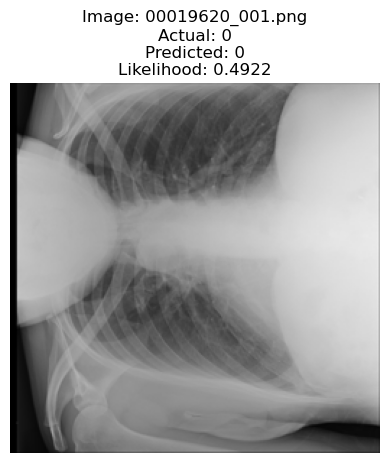

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


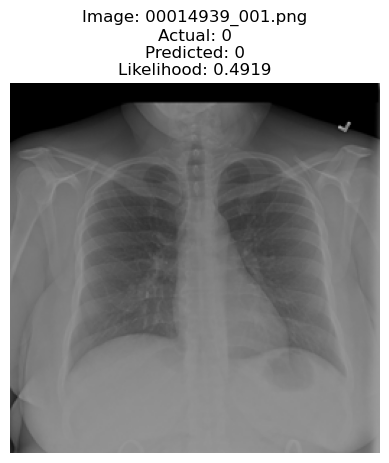

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


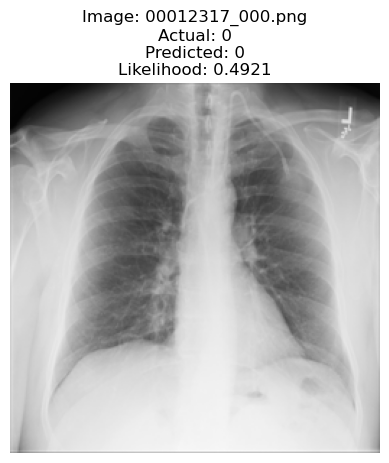

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


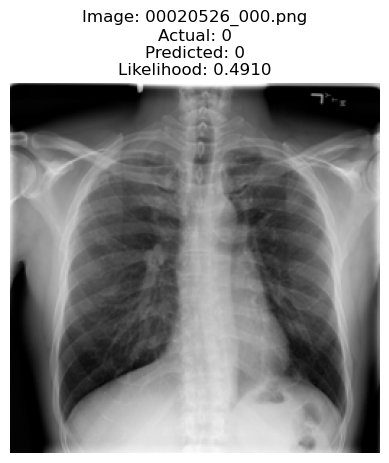

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


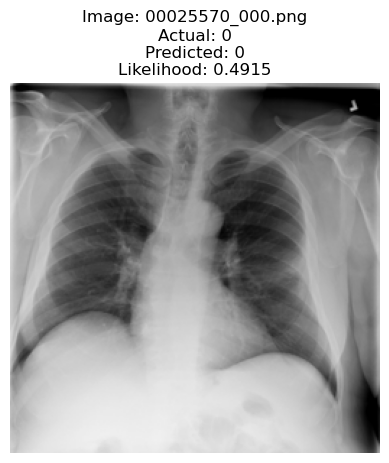

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


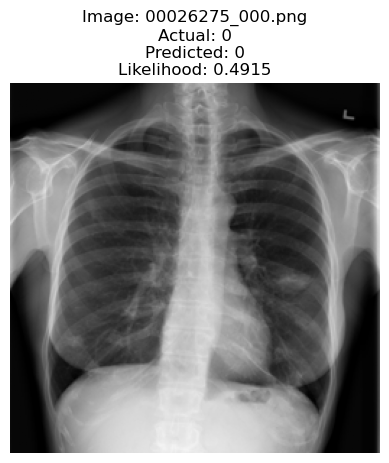

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


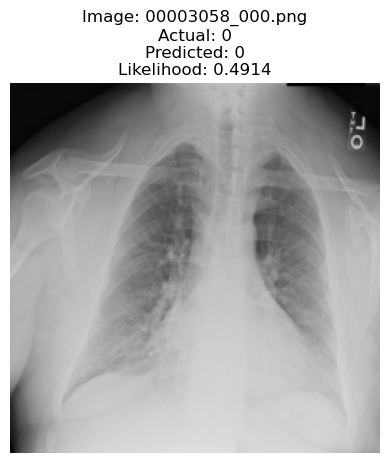

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


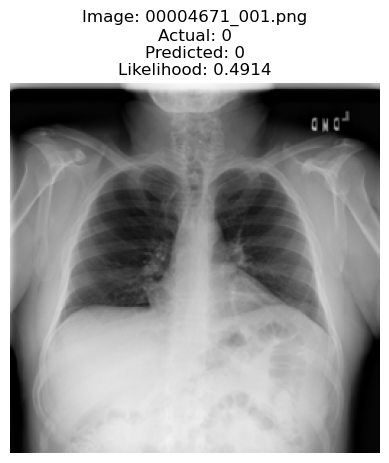

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


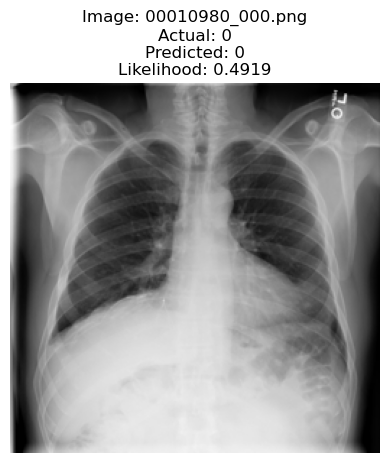

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


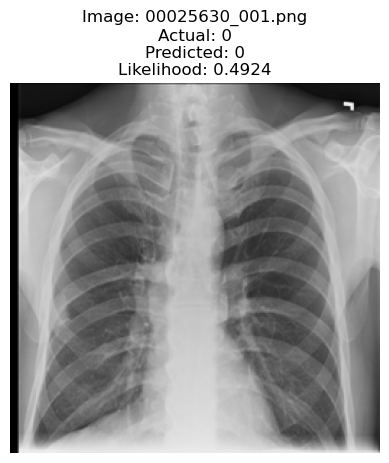

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


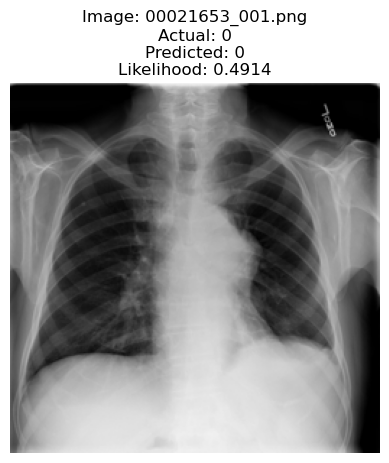

In [3]:

test_images = np.load(os.path.join(base_dir, 'test_images.npy'))
test_labels = np.load(os.path.join(class_dir, f'test_labels_class{modelclass}.npy'))
test_image_names = np.load(os.path.join(base_dir, 'test_image_names.npy'), allow_pickle=True)

if len(test_images.shape) == 3:
    test_images = np.expand_dims(test_images, axis=-1)
    test_images = np.repeat(test_images, 3, axis=-1)

test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_pred = model.predict(test_images)
y_pred_binary = (y_pred > 0.5).astype(int)

cm = confusion_matrix(test_labels, y_pred_binary)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

def display_image_with_predictions(image, image_name, actual_label, predicted_label, likelihood):
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Image: {image_name}\nActual: {actual_label}\nPredicted: {predicted_label}\nLikelihood: {likelihood:.4f}")
    plt.axis('off')
    plt.show()

num_samples = 20
indices = random.sample(range(test_images.shape[0]), num_samples)

for idx in indices:
    image = test_images[idx]
    image_name = test_image_names[idx]
    actual_label = test_labels[idx][0]
    image_expanded = np.expand_dims(image, axis=0)
    prediction = model.predict(image_expanded)[0][0]
    
    threshold = 0.5
    predicted_label = int(prediction > threshold)
    likelihood = prediction
    
    display_image_with_predictions(image, image_name, actual_label, predicted_label, likelihood)